Running strategy: Buy and Hold
    Final wealth = 1.9496, Exponential growth = 0.0027, Sharpe = 2.5060
Running strategy: Best Stock
    Final wealth = 0.1725, Exponential growth = -0.0070, Sharpe = -2.7650
Running strategy: Constant Rebalancing
    Final wealth = 1.9540, Exponential growth = 0.0027, Sharpe = 2.6346
Running strategy: Universal Portfolios
    Final wealth = 1.9569, Exponential growth = 0.0027, Sharpe = 2.6404
Running strategy: Exponential Gradient
    Final wealth = 1.9532, Exponential growth = 0.0027, Sharpe = 2.6231
Running strategy: Follow the Leader
    Final wealth = 1.9685, Exponential growth = 0.0027, Sharpe = 2.5380
Running strategy: Follow the Regularized Leader
    Final wealth = 1.9183, Exponential growth = 0.0026, Sharpe = 2.5367
Running strategy: Aggregation-Based_Simple
    Final wealth = 1.9610, Exponential growth = 0.0027, Sharpe = 2.6328
Running strategy: Anti-Correlation
    Final wealth = 1.9590, Exponential growth = 0.0027, Sharpe = 2.5454
Running str

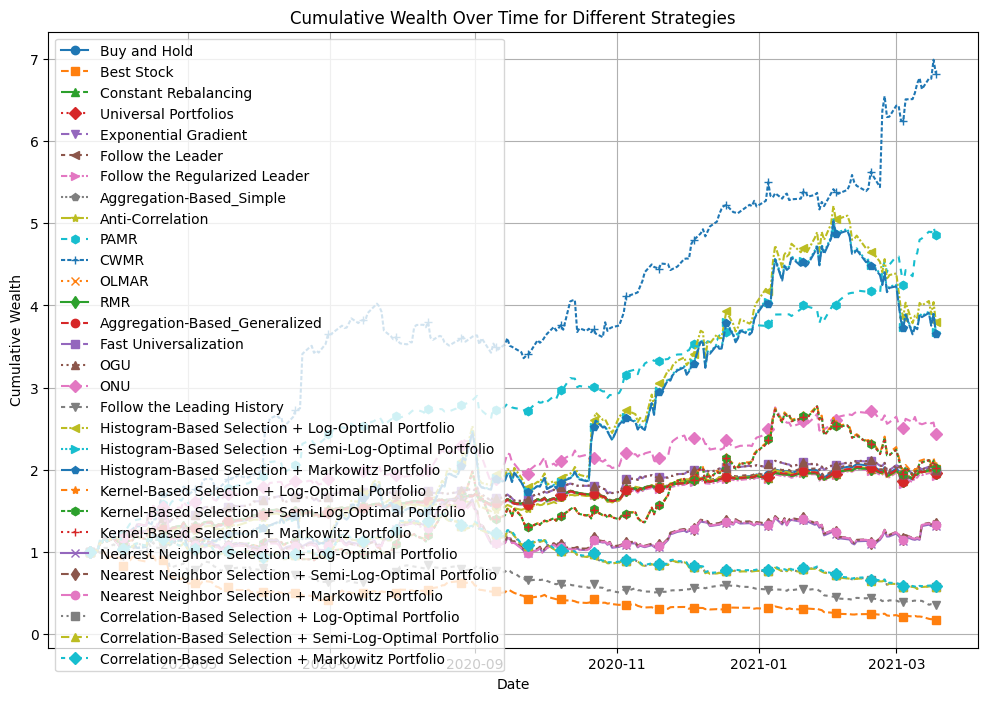


===== Final Sharpe Ratios (Sorted) =====
PAMR: 4.5473
CWMR: 3.6941
Universal Portfolios: 2.6404
Constant Rebalancing: 2.6346
OLMAR: 2.6346
RMR: 2.6346
Aggregation-Based_Simple: 2.6328
Exponential Gradient: 2.6231
Aggregation-Based_Generalized: 2.5738
Anti-Correlation: 2.5454
Follow the Leader: 2.5380
Follow the Regularized Leader: 2.5367
Buy and Hold: 2.5060
Fast Universalization: 2.4617
OGU: 2.4479
Histogram-Based Selection + Log-Optimal Portfolio: 2.1653
ONU: 2.1371
Histogram-Based Selection + Semi-Log-Optimal Portfolio: 2.1284
Histogram-Based Selection + Markowitz Portfolio: 2.1250
Kernel-Based Selection + Log-Optimal Portfolio: 1.4579
Kernel-Based Selection + Semi-Log-Optimal Portfolio: 1.4372
Kernel-Based Selection + Markowitz Portfolio: 1.4349
Nearest Neighbor Selection + Semi-Log-Optimal Portfolio: 0.7874
Nearest Neighbor Selection + Markowitz Portfolio: 0.7797
Nearest Neighbor Selection + Log-Optimal Portfolio: 0.7604
Correlation-Based Selection + Markowitz Portfolio: -0.9414


In [1]:
# ---------------------------------
# Strategy_Comparison.ipynb
# ---------------------------------

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Utility Function Imports
from utilities import *

# Algorithm Imports
from Strategies.benchmarks import *
from Strategies.follow_the_loser import *
from Strategies.follow_the_winner import *
from Strategies.pattern_matching import *
from Strategies.meta_learning import *

# (Optional) If you're using the same folder_path and tickers:
folder_path = "C:\\Users\\nlaha\\OneDrive\\Documents\\Personal\\Quant Research\\Trading Data\\"

nasdaq_100 = [
    "AAPL", "MSFT", "GOOG", "GOOGL", "AMZN", "TSLA",
    "NVDA", "PEP", "COST", "FB", "AVGO", "ADBE",
    "NFLX", "INTC", "PYPL", "CSCO", "CMCSA", "AMD",
    "TXN", "QCOM", "AMAT", "HON", "SBUX", "AMGN",
    "INTU", "ADI", "GILD", "MDLZ", "ADP", "ISRG",
    "BKNG", "CHTR", "TMUS", "MU", "LRCX", "REGN",
    "ASML", "CSX", "MRNA", "VRTX", "PANW", "MRVL",
    "KLAC", "SNPS", "MELI", "FTNT", "WDAY", "IDXX",
    "ORLY", "MNST", "NXPI", "PAYX", "KDP", "EXC",
    "CDNS", "PCAR", "ODFL", "XEL", "ADSK", "ROST",
    "LCID", "EBAY", "CTSH", "CPRT", "MAR", "AEP",
    "TEAM", "ABNB", "CRWD", "VRSK", "ATLX", "CSGP",
    "CHKP", "DLTR", "EA", "FAST", "FISV", "VRSN",
    "SIRI", "MCHP", "PDD", "WDPN", "BKR", "ANSS",
    "ALGN", "CTAS", "CDW", "PCAR", "PAYC", "SGEN",
    "SPLK", "SWKS", "WBD", "ZS"
]

# Get only tickers available locally
all_tickers_in_data = get_all_tickers(folder_path)
all_tickers_in_data = [t.upper() for t in all_tickers_in_data]
tickers = sorted(list(set(nasdaq_100).intersection(all_tickers_in_data)))

# Initialize a uniform portfolio
b = initialize_portfolio(len(tickers))

# Build price relative vectors
price_relative_df = calculate_price_relative_vectors(folder_path, tickers)
price_relative_vectors_array = price_relative_df.values
dates = price_relative_df.index

#---------------------------------
# Part 2: Run All Strategies
#---------------------------------
strategies = {
    'Buy and Hold': buy_and_hold,
    'Best Stock': best_stock,
    'Constant Rebalancing': constant_rebalancing,
    'Universal Portfolios': universal_portfolios,
    'Exponential Gradient': exponential_gradient,
    'Follow the Leader': follow_the_leader,
    'Follow the Regularized Leader': follow_the_regularized_leader,
    'Aggregation-Based_Simple': aggregation_based_simple,
    'Anti-Correlation': anticor,
    'PAMR': pamr,
    'CWMR': cwmr,
    'OLMAR': olmar,
    'RMR': rmr,
    "Aggregation-Based_Generalized": aggregation_algorithm_generalized,
    "Fast Universalization": fast_universalization,
    "OGU": online_gradient_update_meta,
    "ONU": online_newton_update_meta,
    "Follow the Leading History": follow_the_leading_history
}

# Pattern-matching combos
sample_selection_methods = {
    'Histogram-Based Selection': histogram_based_selection,
    'Kernel-Based Selection': kernel_based_selection,
    'Nearest Neighbor Selection': nearest_neighbor_selection,
    'Correlation-Based Selection': correlation_based_selection
}
portfolio_optimization_methods = {
    'Log-Optimal Portfolio': log_optimal_portfolio,
    'Semi-Log-Optimal Portfolio': semi_log_optimal_portfolio,
    'Markowitz Portfolio': markowitz_portfolio
}
combos = []
for ss_name, ss_func in sample_selection_methods.items():
    for po_name, po_func in portfolio_optimization_methods.items():
        combination_name = f"{ss_name} + {po_name}"
        combos.append((combination_name, ss_func, po_func))

# Add pattern-matching combos to strategies
for combination_name, ss_func, po_func in combos:
    def make_pattern_matching_strategy(ss=ss_func, po=po_func):
        def strategy(b, price_rels):
            methods = {'sample_selection': ss, 'portfolio_optimization': po}
            return pattern_matching_portfolio_master(b, price_rels, methods)
        return strategy
    strategies[combination_name] = make_pattern_matching_strategy()

cumulative_wealth_dict = {}
sharpe_dict = {}

line_styles = ['-', '--', '-.', ':',
               (0,(4,2)), (0,(2,2)), (0,(3,1,1,1)), (0,(1,1)),
               (0,(5,1)), (0,(3,3)), (0,(2,1)), (0,(1,2,1,2))]

markers = ['o','s','^','D','v','<','>','p','*','h','+','x','d']

num_strategies = len(strategies)
if len(line_styles) < num_strategies:
    line_styles *= (num_strategies // len(line_styles) + 1)
if len(markers) < num_strategies:
    markers *= (num_strategies // len(markers) + 1)

plt.figure(figsize=(12,8))

for i, (strategy_name, strategy_function) in enumerate(strategies.items()):
    try:
        print(f"Running strategy: {strategy_name}")

        # 1) Get the portfolio weight vectors for each time step
        b_n_strat = strategy_function(b, price_relative_vectors_array)

        # 2) Compute the cumulative wealth path
        cum_wealth = calculate_cumulative_wealth_over_time(b_n_strat, price_relative_vectors_array)
        cumulative_wealth_dict[strategy_name] = cum_wealth

        # 3) Compute exponential growth rate
        final_wealth = cum_wealth[-1]
        n_periods = len(price_relative_vectors_array)
        exp_growth = calculate_exponential_growth_rate(final_wealth, n_periods)

        # 4) Compute daily returns and Sharpe ratio
        daily_returns = compute_periodic_returns(cum_wealth)
        sr = compute_sharpe_ratio(daily_returns, freq=252, risk_free_rate=0.00)
        sharpe_dict[strategy_name] = sr

        print(f"    Final wealth = {final_wealth:.4f}, "
              f"Exponential growth = {exp_growth:.4f}, "
              f"Sharpe = {sr:.4f}")

    except Exception as e:
        print(f"Error in {strategy_name}: {e}")
        continue

# --- Plot
for i, (strategy_name, cum_wealth) in enumerate(cumulative_wealth_dict.items()):
    plt.plot(
        dates, cum_wealth,
        label=strategy_name,
        linestyle=line_styles[i],
        marker=markers[i],
        markevery=10,
        markersize=6,
        linewidth=1.5
    )

plt.title('Cumulative Wealth Over Time for Different Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Wealth')
plt.legend()
plt.grid(True)
plt.show()

print("\n===== Final Sharpe Ratios (Sorted) =====")
sorted_sharpe = sorted(sharpe_dict.items(), key=lambda x: x[1], reverse=True)
for strat_name, sr_val in sorted_sharpe:
    print(f"{strat_name}: {sr_val:.4f}")
